In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("../data/processed/athlete_features_engineered.csv") 

In [3]:
print(df.shape)
df.isna().sum()

(3600, 25)


athlete_id                0
date                      0
height_cm                 0
weight_kg                 0
daily_load                0
acwr                      0
resting_hr                0
hrv                       0
sleep_quality             0
past_injury               0
days_since_injury         0
cns_drift_minutes         0
big_toe_stiffness         0
hrv_z                     0
daily_load_log            0
load_7d                   0
load_14d                  0
hrv_7d_mean               0
hrv_drop                  0
load_7d_std              60
training_monotony        60
training_strain          60
recovery_score            0
training_monotony_log    60
training_strain_log      60
dtype: int64

In [4]:
features_with_nans = ["training_monotony_log","training_strain_log","load_7d_std","training_monotony","training_strain"]
df[features_with_nans] = df.groupby("athlete_id")[features_with_nans].ffill()
df[features_with_nans] = df.groupby("athlete_id")[features_with_nans].bfill()

In [5]:
df.isna().sum()

athlete_id               0
date                     0
height_cm                0
weight_kg                0
daily_load               0
acwr                     0
resting_hr               0
hrv                      0
sleep_quality            0
past_injury              0
days_since_injury        0
cns_drift_minutes        0
big_toe_stiffness        0
hrv_z                    0
daily_load_log           0
load_7d                  0
load_14d                 0
hrv_7d_mean              0
hrv_drop                 0
load_7d_std              0
training_monotony        0
training_strain          0
recovery_score           0
training_monotony_log    0
training_strain_log      0
dtype: int64

In [6]:
'''athlete_id,date,height_cm,weight_kg,daily_load,acwr,
resting_hr,hrv,sleep_quality,past_injury,days_since_injury,
cns_drift_minutes,big_toe_stiffness,hrv_z,daily_load_log,
load_7d,load_14d,hrv_7d_mean,hrv_drop,load_7d_std,
training_monotony,training_strain,recovery_score,
training_strain_log,training_monotony_log'''

def minmax(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-6)

load_risk     = minmax(df["load_7d"])
fatigue_risk  = minmax(-df["hrv_drop"])
monotony_risk = minmax(df["training_monotony_log"])
recovery_risk = 1 - minmax(df["recovery_score"])


In [7]:
history_risk = (
    df["past_injury"] *
    np.exp(-df["days_since_injury"] / 60)
)

In [8]:
df["history_risk"] = history_risk

In [9]:
df["risk_score"] = (
    0.25 * load_risk +
    0.25 * fatigue_risk +
    0.15 * monotony_risk +
    0.20 * recovery_risk +
    0.15 * history_risk
)


In [10]:
q1 = df["risk_score"].quantile(0.4)
q2 = df["risk_score"].quantile(0.9)

In [11]:
def classify_risk(score):
    if pd.isna(score):
        return "Unknown"
    elif score < q1:
        return "Safe"
    elif score < q2:
        return "Moderate"
    else:
        return "High"

In [12]:
df["risk_zone"] = df["risk_score"].apply(classify_risk)

In [13]:
df["risk_zone"].value_counts()

risk_zone
Moderate    1800
Safe        1440
High         360
Name: count, dtype: int64

In [14]:
train_parts = []
test_parts = []

for athlete_id, g in df.groupby("athlete_id"):
    split_idx = int(len(g) * 0.8)  # 48 days
    
    train_parts.append(g.iloc[:split_idx])
    test_parts.append(g.iloc[split_idx:])


In [15]:
train_df = pd.concat(train_parts).reset_index(drop=True)
test_df  = pd.concat(test_parts).reset_index(drop=True)

In [16]:
# Each athlete has future days only in test
assert all(
    train_df.groupby("athlete_id")["date"].max()
    < test_df.groupby("athlete_id")["date"].min()
)

In [17]:
'''splitting EACH athlete’s timeline independently:
first 48 days → train, last 12 days → test'''
print(train_df.shape)  # ~2880
print(test_df.shape)   # ~720

(2880, 28)
(720, 28)


In [18]:
features = [
    "load_7d",
    "hrv_drop",
    "training_monotony_log",
    "recovery_score",
    "history_risk"
]

X_train = train_df[features]
y_train = train_df["risk_zone"]

X_test = test_df[features]
y_test = test_df["risk_zone"]


In [19]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]


In [20]:
print(y_train.value_counts())
print(y_test.value_counts())


risk_zone
Moderate    1351
Safe        1251
High         278
Name: count, dtype: int64
risk_zone
Moderate    449
Safe        189
High         82
Name: count, dtype: int64


In [21]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print(le.classes_)  # ['High', 'Moderate', 'Safe']


['High' 'Moderate' 'Safe']


In [22]:
logreg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

logreg.fit(X_train, y_train_enc)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [23]:
y_pred = logreg.predict(X_test)
print("Accuracy:", accuracy_score(y_test_enc, y_pred))

Accuracy: 0.9027777777777778


In [24]:
print(classification_report(
    y_test_enc,
    y_pred,
    target_names=le.classes_
))

              precision    recall  f1-score   support

        High       0.80      0.87      0.83        82
    Moderate       0.97      0.87      0.92       449
        Safe       0.82      1.00      0.90       189

    accuracy                           0.90       720
   macro avg       0.86      0.91      0.88       720
weighted avg       0.91      0.90      0.90       720



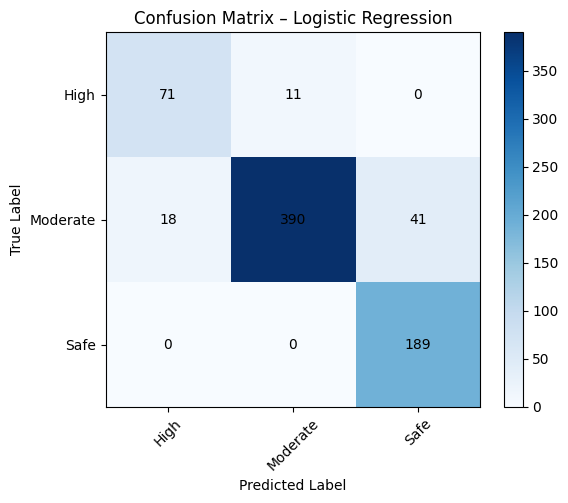

In [25]:
# compute confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)

# plot
plt.figure(figsize=(6, 5))
plt.imshow(cm,cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression")
plt.colorbar()

tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

# annotate values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center"
        )

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [26]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train_enc)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [27]:
y_pred_rf = rf.predict(X_test)

In [28]:
print("Random Forest Accuracy:", accuracy_score(y_test_enc, y_pred_rf))

Random Forest Accuracy: 0.9263888888888889


In [29]:
print(classification_report(
    y_test_enc,
    y_pred_rf,
    target_names=le.classes_
))

              precision    recall  f1-score   support

        High       0.90      0.78      0.84        82
    Moderate       0.93      0.96      0.94       449
        Safe       0.93      0.92      0.93       189

    accuracy                           0.93       720
   macro avg       0.92      0.89      0.90       720
weighted avg       0.93      0.93      0.93       720



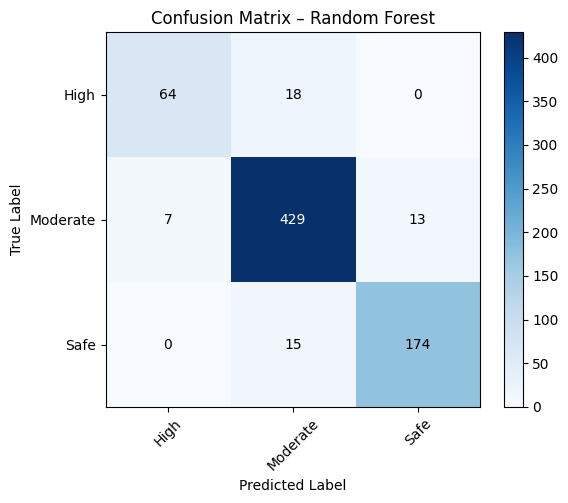

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm_rf = confusion_matrix(y_test_enc, y_pred_rf)

plt.figure(figsize=(6, 5))
plt.imshow(cm_rf, cmap="Blues")
plt.title("Confusion Matrix – Random Forest")
plt.colorbar()

tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

threshold = cm_rf.max() / 2
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        plt.text(
            j, i, cm_rf[i, j],
            ha="center", va="center",
            color="white" if cm_rf[i, j] > threshold else "black"
        )

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [31]:
feat_imp = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(feat_imp)

load_7d                  0.335847
recovery_score           0.287020
hrv_drop                 0.256863
training_monotony_log    0.085780
history_risk             0.034491
dtype: float64


In [32]:
from sklearn.preprocessing import label_binarize
# Class order must match model.classes_
class_names = logreg.classes_   # or rf.classes_

y_test_bin = label_binarize(y_test_enc, classes=range(len(class_names)))

y_proba = rf.predict_proba(X_test)   # model = logreg or rf


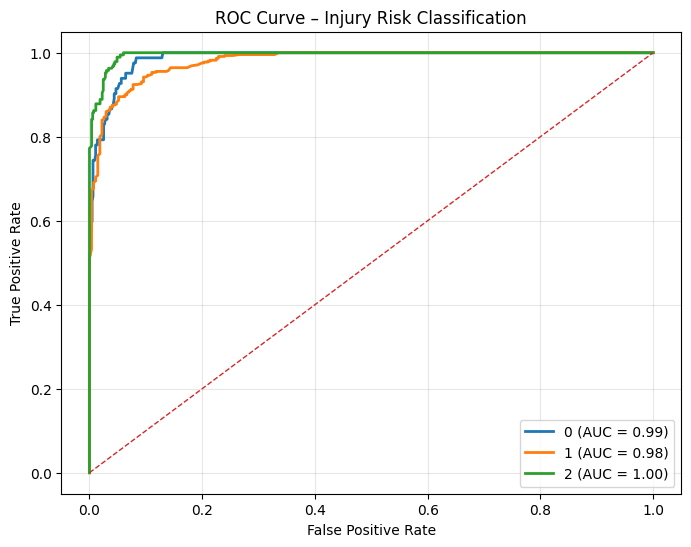

In [33]:
from sklearn.metrics import auc
plt.figure(figsize=(8,6))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(
        fpr, tpr,
        linewidth=2,
        label=f"{class_name} (AUC = {roc_auc:.2f})"
    )

# Diagonal
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Injury Risk Classification")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [35]:
import joblib
import os

# create models directory if it doesn't exist
# os.makedirs("models", exist_ok=True)

# save trained models and label encoder
joblib.dump(logreg, "../models/risk_model_logreg.pkl")
joblib.dump(rf, "../models/risk_model_rf.pkl")
joblib.dump(le, "../models/label_encoder.pkl")

print("✅ Models saved successfully")
print("Saved files:")
print("- models/risk_model_logreg.pkl")
print("- models/risk_model_rf.pkl")
print("- models/label_encoder.pkl")
print("Classes:", list(le.classes_))


✅ Models saved successfully
Saved files:
- models/risk_model_logreg.pkl
- models/risk_model_rf.pkl
- models/label_encoder.pkl
Classes: ['High', 'Moderate', 'Safe']
